In [82]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from lib.Utility import exportExcelWithTimeStamp

from datetime import date, timedelta
import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
import numpy as np # Fundamental package for scientific computing with Python
import joblib
import plotly.express as px
from plotly import graph_objects as go
# Train the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

# features = ['B365H','B365D', 'B365A', 'B365>2.5',	'B365<2.5']
features = ['HomeGoalsCumulative', 'AwayGoalsCumulative', 'HomePointsCumulative','AwayPointsCumulative', 'HomeGoalsConcededCumulative',	'AwayGoalsConcededCumulative']
features = ['HomeGoalsCumulative', 'AwayGoalsCumulative', 'AwayPointsCumulative', 'HomeGoalsConcededCumulative']
features = ['HomeGoalsCumulative', 'AwayGoalsConcededCumulative']

threshold = 0.35

In [83]:
# data = pd.read_excel('data/mergedData.xlsx')
# data = pd.read_excel('data/engdata/24-25.xlsx')
data = pd.read_excel('data/mergedDataSerieB.xlsx')
# data['Cluster'] = np.where(data['FTR'] == 'H', 1, np.where(data['FTR'] == 'A', 2, 0))
data['Cluster'] = np.where(data['FTHG'] == data['FTAG'], 1, 0)
# data = data[data['HomeGoalsCumulative'].notna()]
# data = data[data['AwayGoalsCumulative'].notna()]
# data = data[data['HomePointsCumulative'].notna()]
# data = data[data['AwayPointsCumulative'].notna()]
# data = data[data['HomeGoalsConcededCumulative'].notna()]
# data = data[data['AwayGoalsConcededCumulative'].notna()]
# data.dropna()
data.tail()

,Date,Div,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgCAHH,AvgCAHA,HomeGoalsCumulative,AwayGoalsCumulative,HomePointsCumulative,AwayPointsCumulative,HomeGoalsConcededCumulative,AwayGoalsConcededCumulative,MatchGoal,Cluster
1895,1970-01-01 01:00:45.422,I2,19:30:00,FeralpiSalo,Ternana,0,1,A,0.0,1.0,...,1.91,1.91,44,42,33,40,64,50,1,0
1896,1970-01-01 01:00:45.422,I2,19:30:00,Lecco,Modena,2,3,A,1.0,3.0,...,1.86,1.94,33,38,26,44,71,45,5,0
1897,1970-01-01 01:00:45.422,I2,19:30:00,Reggiana,Parma,1,1,D,1.0,0.0,...,2.07,1.76,37,65,46,75,44,34,2,1
1898,1970-01-01 01:00:45.422,I2,19:30:00,Spezia,Venezia,2,1,H,0.0,1.0,...,1.94,1.87,34,68,41,70,48,44,3,0
1899,1970-01-01 01:00:45.422,I2,19:30:00,Sudtirol,Palermo,0,1,A,0.0,0.0,...,1.83,1.98,46,61,47,53,47,53,1,0


In [84]:
x_train, x_test, y_train, y_test = train_test_split(data[features], data['Cluster'], test_size= 0.3, random_state= 42,shuffle=True)

x_train = x_train.sort_index()
x_test = x_test.sort_index()
y_train= y_train.sort_index()
y_test = y_test.sort_index()

print (f'X_train: {x_train.shape} \nX_test: {x_test.shape} \ny_train: {y_train.shape} \ny_test: {y_test.shape}')


X_train: (1330, 2) 
X_test: (570, 2) 
y_train: (1330,) 
y_test: (570,)


In [85]:
# Set regularization rate
# reg = 0.01

# train a logistic regression model on the training set
# model = LogisticRegression(C=1/reg, solver="liblinear", random_state=42).fit(x_train, y_train)

# joblib.dump(model, "./Soccer-ml1.joblib")

model = joblib.load("Soccer-ml2.joblib")

In [86]:
def custom_predict(X, threshold):
    probs = model.predict_proba(X) 
    return (probs[:, 1] > threshold).astype(int)

In [87]:
x_test = data[features]
y_test = data['Cluster']

df = x_test.copy()
# df['predictions'] = model.predict(x_test.sort_index())
df['predictions'] = custom_predict(x_test.sort_index(), threshold)
pred_prob = model.predict_proba(x_test.sort_index())

df2 = pd.DataFrame(pred_prob)
df2.index = df.index
df = df.merge(df2, left_index=True, right_index=True)

finalDataset = data[data.index.isin(x_test.index)]
finalDataset['predictions'] = df['predictions']
finalDataset['pred_prob'] = df[1]
finalDataset['gain'] = np.where((finalDataset['FTR'] == 'D') & (finalDataset['predictions'] > threshold),
                                finalDataset['B365D']-1, np.where((finalDataset['FTR'] != 'D') & (finalDataset['predictions'] > threshold), -1, 0))
equity = finalDataset['gain'].sum()
print(equity)

print(f"Accuracy score: {accuracy_score(y_test, df['predictions'])}")
exportExcelWithTimeStamp(finalDataset, "Dataframe/", "df.xlsx")

0.0
Accuracy score: 0.6873684210526316


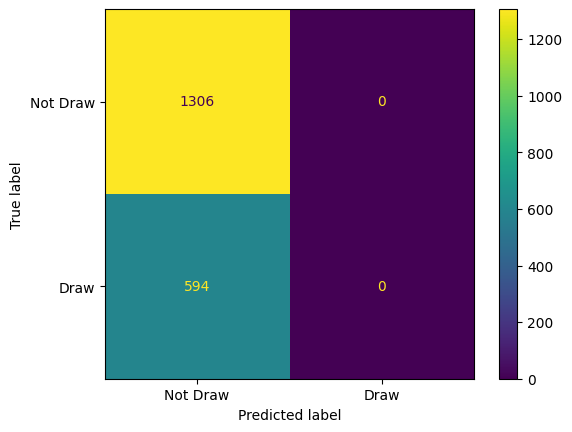

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y_true = y_test
y_pred = df['predictions']
matrix = confusion_matrix(y_true, y_pred)
matrix.diagonal()/matrix.sum(axis=1)

# visualize confusion matrix with sklearn metrics
# define matrix and create labels
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ["Not Draw", "Draw"])

# display matrix
cm_display.plot()
plt.show()